In [1]:
# standard python tools
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from skimage.io import imread

In [2]:
# make sure pyqae is available
try:
    import pyqae as pq
except ImportError:
    import sys
    sys.path.append('/Users/mader/Dropbox/Informatics/pyqae-master')
    import pyqae as pq
    
# check to see if it is running on pyspark
try:
    import pyspark
except ImportError:
    print('Using a fake spark backend for processing')
    import pyqae.simplespark as pyspark
    sc = pyspark.LocalSparkContext()

from pyqae.images import viz
from pyqae.sitk import read_to_dataframe, ITKImage

# DataFrame Representation
The dataframe representation of the files is shown below. The columns are listed in the subsequent fields. The ```itk_```, ```array``` and ```array_dtype``` are necessary for recreating the ITK image and should not be modified

In [3]:
base_path = "/Users/mader/Dropbox/4Quant/Projects/TumorSegmentation/10092825/"
mri_df = read_to_dataframe(glob(os.path.join(base_path,"0004_t1_tse_sag_384/*.tif")), context = sc)

In [4]:
", ".join(mri_df.columns)

'ImageDescription, Tag 50838, Tag 50839, array, array_dtype, filename, itk_Depth, itk_Dimension, itk_Direction, itk_Height, itk_NumberOfComponentsPerPixel, itk_Origin, itk_PixelID, itk_PixelIDTypeAsString, itk_PixelIDValue, itk_Size, itk_Spacing, itk_Width'

# Running SQL Commands
The ```DataFrame``` can be registered as a table which allows for further processing to be done using SQL and the DataFrame interface

In [5]:
mri_df.registerTempTable("TestTable")

In [6]:
sqlContext.sql("""SELECT filename, itk_Size, itk_Spacing, ImageDescription FROM TESTTable ORDER BY itk_Size._1 LIMIT 2""").toPandas()

,filename,itk_Size,itk_Spacing,ImageDescription
0,/Users/mader/Dropbox/4Quant/Projects/TumorSegm...,"(384, 384)","(1.0, 1.0)",ImageJ=1.49v\nunit=mm\nmin=0.0\nmax=1128.0\n
1,/Users/mader/Dropbox/4Quant/Projects/TumorSegm...,"(384, 384)","(1.0, 1.0)",ImageJ=1.49v\nunit=mm\nmin=0.0\nmax=1128.0\n


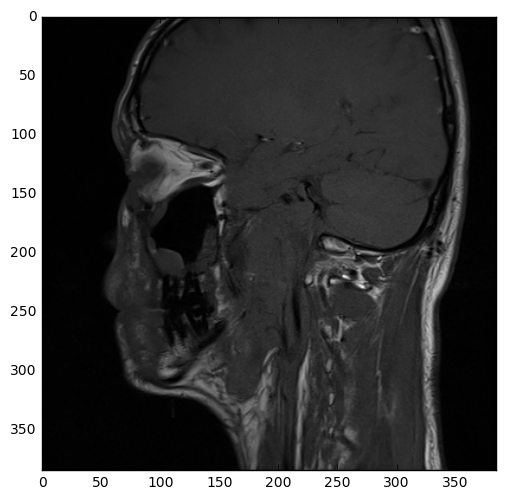

In [7]:
sqlContext.sql("""SELECT * FROM TESTTable LIMIT 2""").rdd.map(lambda x: ITKImage._parse_dict(x.asDict())).first().show()

# 3D Volumes
The tools can also be applied for looking at 3D volumes by taking stacks of slices together.

In [8]:
fold_name = lambda x: os.path.split(os.path.split(x)[0])[1]
base_path = "/Users/mader/Dropbox/4Quant/Projects/TumorSegmentation/10092825/"
grp_paths = sc.parallelize(glob(os.path.join(base_path,"*/*.dcm"))).groupBy(fold_name).map(lambda x: list(x[1]))
mri_3d_df = read_to_dataframe(grp_paths)
mri_3d_df.registerTempTable("TdTable")

In [17]:
sqlContext.sql("""
SELECT  
itk_Size as ImageDimensions, 
itk_Size._1*itk_Size._2*itk_Size._3 as VoxelCount,
itk_Spacing as ImageResolution 
FROM TdTable ORDER BY VoxelCount DESC LIMIT 2""").toPandas()

,ImageDimensions,VoxelCount,ImageResolution
0,"(130, 130, 240)",4056000,"(2.0, 2.0, 4.999996185302734)"
1,"(384, 384, 16)",2359296,"(0.57291668653488, 0.57291668653488, 6.0)"


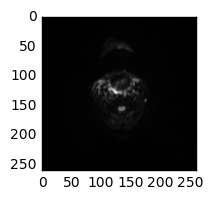

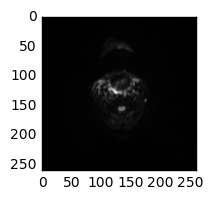

In [18]:
out_img = sqlContext.sql("""SELECT * FROM TdTable
ORDER BY itk_Size._1*itk_Size._2*itk_Size._3 DESC LIMIT 1""").rdd.map(lambda x: ITKImage._parse_dict(x.asDict())).first()
_ = out_img.show()